# Milestone Project 1: Food Vision Big

See the annotated version of this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

## Check GPU

Google Colab offers free GPUs (thank you Google), however not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not campatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

In [39]:
# Check to see if we're using a GPU
!nvidia-smi -L
!nvidia-smi

GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU (UUID: GPU-2349283b-d8c3-574d-bb05-0097332584c3)
Fri Jul  1 06:36:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8    17W /  N/A |   5102MiB /  6144MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+---------------------

## Get helper functions

In past modules, we've created a bunch of helper functions to do small task required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on GitHub: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [40]:
# Download helper functions script
import os
if not os.path.exists("helper_functions.py"):
    !python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [41]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Dataset to download data

If you want to get an overview of TensorFlow (TFDS) read the guide: https://www.tensorflow.org/datasets/

In [42]:
# Get TensorFlow dataset
import tensorflow_datasets as tfds

In [43]:
# List all available dataset
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target in the list of TFDS datasets?

True


In [44]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(
    name="food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True, # data gets returned in tuple format (data, label)
    with_info=True
)

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [45]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [46]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [47]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # Samples are in format (image_tensor, label)

In [48]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [49]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f"""
    Image Shape: {image.shape},
    Image datatype: {image.dtype},
    Traget class from Food101 (tensor form): {label},
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image Shape: (512, 512, 3),
    Image datatype: <dtype: 'uint8'>,
    Traget class from Food101 (tensor form): 72,
    Class name (str form): pancakes
    


In [50]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 42,  40,  51],
        [ 41,  39,  50],
        [ 40,  38,  49],
        ...,
        [ 50,  23,   6],
        [ 51,  24,   7],
        [ 51,  24,   7]],

       [[ 41,  39,  50],
        [ 41,  39,  50],
        [ 41,  39,  50],
        ...,
        [ 47,  20,   3],
        [ 48,  21,   4],
        [ 49,  22,   5]],

       [[ 40,  38,  49],
        [ 41,  39,  50],
        [ 42,  40,  51],
        ...,
        [ 47,  20,   3],
        [ 48,  21,   4],
        [ 48,  21,   4]],

       ...,

       [[188, 180, 191],
        [188, 180, 191],
        [189, 181, 192],
        ...,
        [179, 178, 186],
        [177, 176, 184],
        [175, 174, 182]],

       [[185, 177, 188],
        [186, 178, 189],
        [187, 179, 190],
        ...,
        [178, 177, 185],
        [176, 175, 183],
        [175, 174, 182]],

       [[179, 171, 182],
        [181, 173, 184],
        [183, 175, 186],
        ...,
        [177, 176, 18

In [51]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Dataset

(-0.5, 511.5, 511.5, -0.5)

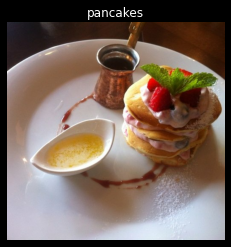

In [52]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False)

## Create preprocessing function for our data

Neural Networks perform best, when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data: 
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixes precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (valules between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from `tf.keras.applications` we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

In [61]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from `uint8` ->  `float32` and reshapes image to [img_shape, img_shape, colour_channels]
    """
    img = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [62]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image befor preprocessing: \n{image[:2]}\nShape: {image.shape}\n{image.dtype}\n")
print(f"Image after preprocessing: \n{preprocessed_img[:2]}\nShape: {preprocessed_img.shape}\n{preprocessed_img.dtype}")

Image befor preprocessing: 
[[[42 40 51]
  [41 39 50]
  [40 38 49]
  ...
  [50 23  6]
  [51 24  7]
  [51 24  7]]

 [[41 39 50]
  [41 39 50]
  [41 39 50]
  ...
  [47 20  3]
  [48 21  4]
  [49 22  5]]]
Shape: (512, 512, 3)
<dtype: 'uint8'>

Image after preprocessing: 
[[[42. 40. 51.]
  [41. 39. 50.]
  [40. 38. 49.]
  ...
  [50. 23.  6.]
  [51. 24.  7.]
  [51. 24.  7.]]

 [[41. 39. 50.]
  [41. 39. 50.]
  [41. 39. 50.]
  ...
  [47. 20.  3.]
  [48. 21.  4.]
  [49. 22.  5.]]]
Shape: (512, 512, 3)
<dtype: 'float32'>


## Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this, I'd highly recommend going through the following guide: https://www.tensorflow.org/guide/data_performance

In [64]:
# Map preprocessing function to training (ana parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1_000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [65]:
train_data, test_data

(<ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>,
 <_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>)